In [20]:
import vbz_h5py_plugin
import h5py
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# set the filepath for the directory containing all the fast5 files
filepath = "./sample_fast5/subset_fast5/"

# get a list of all files in the directory
dir_list = os.listdir(filepath)

In [3]:
def convert_hdf5_arr(dataset):
    '''
    convert_hdf5_arr takes in a hdf5 dataset object, 
    and then converts it to a numpy array of the same type.
    Note: To Work, this dataset needs to be open. 
    
    Parameters:
    dataset: hdf5 dataset of interest.
    
    Returns:
    a numpy array of same length as the original dataset, 
    containing int16 values.
    '''
    # Get the shape of data
    shp = (dataset.shape)[0]
    
    # Generate an empty int16 numpy array
    arr = np.zeros((shp,), dtype='int16')
    
    # read the dataset to the array
    dataset.read_direct(arr)
    
    # return the array
    return arr

In [57]:
def get_datasets(filename):
    '''
    get_datasets takes in a fast5 filename, and then extracts the 
    signal data to a dictionary of each of the reads.
    
    Parameters:
    filename: File name, as a string, including path to the file
    
    Returns:
    a dictionary with read name as keys, and a numpy array of the signal vals
    '''
    
    # Set up a list to hold each read in the file
    fast5_list = []
    
    # open the file using h5py and the filename in read-mode
    f = h5py.File(filename, 'r')
    
    # Loop through each key in the file
    for data_name in list(f.keys()):
        
        # Get read's dataset
        dataset = f[data_name]
        
        # Get dataset's attributes
        dataset_attributes = dataset['channel_id'].attrs
        
        # Get the read's signal dataset
        signal_dataset = dataset['Raw/Signal']
        
        # Convert the signal data to a numpy array
        signal = convert_hdf5_arr(signal_dataset)
        
        # Get the offset to convert to picoampere scale
        offset = dataset_attributes['offset']
        
        # Get sampling frequency, convert to time step
        freq = dataset_attributes['sampling_rate']
        time_step = 1/freq # units of seconds
        
        # Generate the time column by making a numpy array
        # filling it with the time step, and cumulatively summing
        time = np.full((signal_dataset.shape)[0], time_step)
        time = np.cumsum(time)
        
        # Get the scale to convert to picoampere scaling
        scale = dataset_attributes['range']/dataset_attributes['digitisation']
        
        # convert to picoamperes
        picoampere_signal = (signal + offset)*scale
        
        # generate coulombs per read measure:
        amp_signal = picoampere_signal / 1000000000000
        coulomb_signal = amp_signal*time_step
        
        e_signal = np.rint(coulomb_signal*6.241509*(10**18))
        true_curr = e_signal/(6.241509*(10**18))/time_step*1000000000000
        
        # parse for the read id
        read_id = data_name.split('read_')[1]
        
        # generate a dictionary with the useful info
        read_dict = {'read_id': read_id,
                     'time [s]': time,
                     'signal [pA]': picoampere_signal,
                     'coulombs_transmitted [C]': coulomb_signal,
                     'electron-signal [pA]': true_curr}
        
        # add it to the list
        fast5_list.append(read_dict)

    # Close the file
    f.close()
    
    #return the list
    return fast5_list

In [58]:
dd = get_datasets(filepath + dir_list[0])

In [59]:
ddf = pd.DataFrame(dd)

In [38]:
def make_plot_read(read_dict, ax):
    readkey = 'read_id'
    xkey = 'time [s]'
    ykey = 'signal [pA]'
    ax.set_title('Read {}'.format(read_dict[readkey]))
    ax.plot(read_dict[xkey], read_dict[ykey])
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_ylim(0)
    return ax

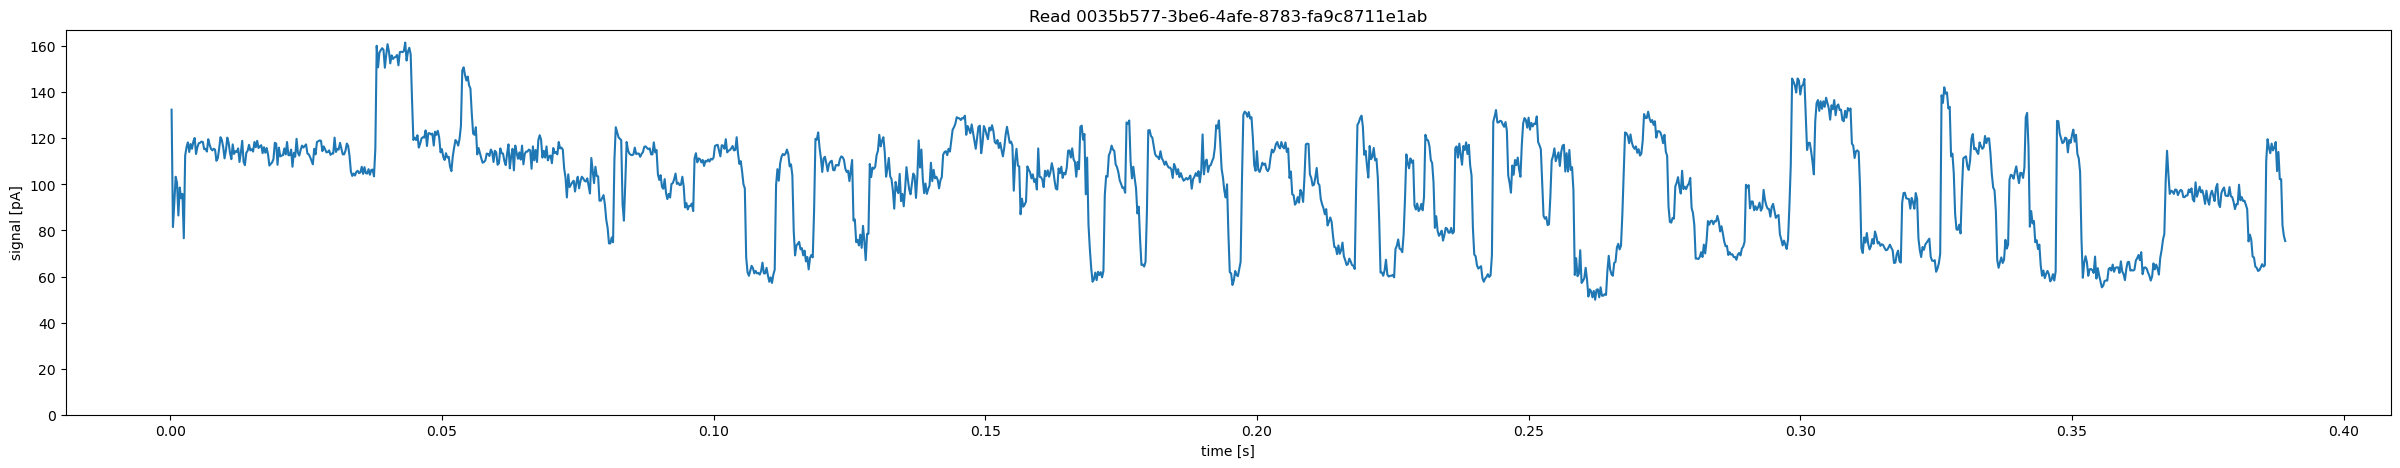

In [60]:
fig, ax = plt.subplots(1, figsize = (30, 5))
gen_ax = make_plot_read(dd[0], ax)

In [55]:
electrons_transmitted = dd[0]['coulombs_transmitted [C]']*6.241509*(10**18)
electrons_transmitted = np.rint(electrons_transmitted)
ap_coulombs = electrons_transmitted/(6.241509*(10**18))

0.0003203559088831298

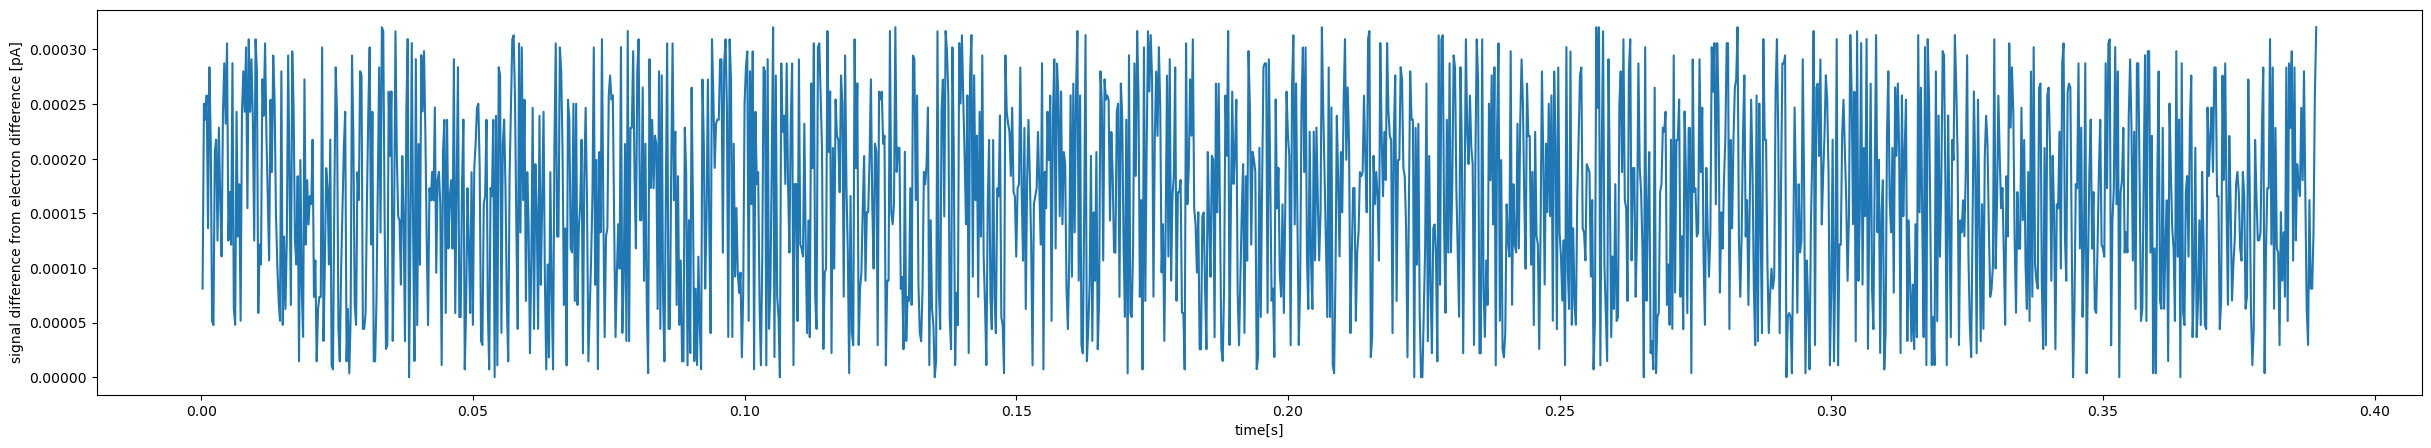

In [69]:
y = pd.Series(dd[0]['electron-signal [pA]'])
y2 = pd.Series(dd[0]['signal [pA]'])
fig, ax = plt.subplots(1, figsize = (30, 5))
ax.plot(dd[0]['time [s]'], np.abs(y-y2))
ax.set_xlabel('time[s]')
ax.set_ylabel('signal difference from electron difference [pA]')
#is this noise? 
np.abs(y-y2).max() #(maximum difference, in picoamperes, between the signal and the electron signal)

### The following is for reference and demonstrating that the methods I am using yeild the same values as if I were to use the pod5 conversion

In [8]:
# Filestructure analysis: --- FOR REFERENCE ONLY ---
f = h5py.File(filepath + dir_list[0], 'r')
# Level 1, keys are read names
read_names = list(f.keys())
# Level 2, keys are ['Raw', 'channel_id', 'context_tags', 'tracking_id']
data_names = list(f[read_names[0]].keys())
# Level 3:
#     Raw: Contains one set of data, the signal
signal_key = list(f[read_names[0]][data_names[0]].keys())
signal = f[read_names[0]][data_names[0]][signal_key[0]][0]
#     channel_id: Empty
#     context_tags: Empty
#     tracking_id: Empty
f.close()

OSError: Can't synchronously read data (can't open directory)

In [7]:
signal

<Closed HDF5 dataset>

In [103]:
# Converting fast5 to pod5 using pod5
pat = "/fe85b517-62ee-4a33-8767-41cab5d5ab39.fast5"
f = h5py.File(filepath + dir_list[0], 'r')
# Level 1, keys are read names
read_names = list(f.keys())
data_names = list(f[read_names[0]].keys())

read_names[0].split('read_')[1]

'0035b577-3be6-4afe-8783-fa9c8711e1ab'

In [9]:
import pod5
import pod5.tools.pod5_convert_from_fast5 as p5t
from typing import Dict

C:\Users\Sebastian\anaconda3\envs\xna_seq\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [82]:
run_info_cache: Dict[str, pod5.RunInfo] = {}
pod5_read = p5t.convert_fast5_read(f[read_names[0]], run_info_cache)

In [104]:
str(pod5_read.read_id)
read_names[0].split('read_')[1]

'0035b577-3be6-4afe-8783-fa9c8711e1ab'

In [105]:
pod5_read.decompressed_signal
convert_hdf5_arr(f[read_names[0]]['Raw/Signal'])

array([757, 463, 523, ..., 467, 441, 428], dtype=int16)

In [120]:
offset = f[read_names[0]].channel_id.attrs['offset']
adcrn = f[read_names[0]]['channel_id'].attrs['range']
digi = f[read_names[0]]['channel_id'].attrs['digitisation']
(offset, adcrn/digi)

AttributeError: 'Group' object has no attribute 'channel_id'

In [121]:
f[read_names[0]]['channel_id'].attrs['sampling_rate']

4000.0

In [99]:
pod5_read.calibration

Calibration(offset=7.0, scale=0.17338497936725616)

In [92]:
pod5_read.star

312227

In [ ]:
#use remora to take a pod5 read object and a bam read object
'''
1.Take bam fie
2.convert to an alignmentFile via pysam

3.using the same header as the alignmentsfile, read through each read in
the bam file and write it to the primary alignments if it is the primary

4.using pysam, sort the output of the bam file with -o parameter, and give it an index
'''
'''
What Pysam is doing:
generating an alignemtn file and parsing the data from a BAM 
BAM mode is rb
SAM mode is r
wb is write to bam
w is write to sam
idk how its sorting,
but it is a list of read alignments for the primary read

'''
'''
Take the pod5read and the bam read, input into remora
remora then generates a read object from the pod5 and the alignment primary BAM file
read object is generated:
    read id = string of the read id from pod5 
    dacs = the signal from pod5 read record (default is 3'-5')
    shift_dacs_to_pa = pod5.calibration.offset (shift parameter to conert DACs to picoampere scaling)
    scale_dacs_to_pa = pod5.read_record.calibration.scale (scale parameter to convert from picoampere to norm scaling)
alignment is then added from the bam data:
    Im not even gonna deal, but basically it adds the alingnment
    and returns the reference regioun object
'''
'''
reference region.ctg is then got,
'''